# 线性回归的从零开始实现

首先，导入本节中实验所需的包或模块，其中的 matplotlib 包可用于作图，且设置成嵌入显示。

In [56]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
from mxnet import autograd,nd
import random

## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为 1000，输入个数（特征数）为 2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪音项 $\epsilon$ 来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪音项 $\epsilon$ 服从均值为 0 和标准差为 0.01 的正态分布。下面，让我们生成数据集。

In [139]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = np.random.normal(scale=1, size=(num_examples, num_inputs))

labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1] + true_b
labels += np.random.normal(scale=0.01, size=labels.shape)

注意到features的每一行是一个长度为 2 的向量，而labels的每一行是一个长度为 1 的向量（标量）。

In [17]:
features.shape, labels.shape

((1000, 2), (1000,))

In [18]:
features[0], labels[0]

(array([-1.14245292, -0.3765555 ]), 3.2008155780581387)

通过生成第二个特征features[:, 1]和标签 labels 的散点图，我们可以更直观地观察两者间的线性关系。

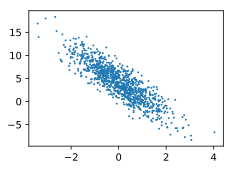

In [22]:
def use_svg_display():
    # 用矢量图显示。
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸。
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1], labels, 1);

## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [109]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机顺序读取样本
    for idx in range(0, num_examples, batch_size):
        j = np.array(indices[idx: min(idx + batch_size, num_examples)])
        yield features.take(j, axis=0), labels.take(j, axis=0)
        
def data_iter_mxnet(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机顺序读取样本
    for idx in range(0, num_examples, batch_size):
        j = nd.array(indices[idx: min(idx + batch_size, num_examples)])
        yield features.take(j), labels.take(j)

读取第一个小批量数据样本并打印。每个批量的特征形状为（10， 2），分别对应批量大小和输入个数；标签形状为批量大小。

In [41]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break
    

[[ 0.02971132 -0.48514308]
 [ 1.55341471 -0.31279343]
 [-0.02936495 -0.29499794]
 [ 1.32575407 -0.2756618 ]
 [-0.46574069 -0.68210856]
 [-0.37449169  1.38837821]
 [-0.20541584 -0.54331695]
 [-0.98781573 -0.86747559]
 [-0.46675902  0.81277051]
 [ 1.24938214  0.56484094]] [ 5.89247975  8.38279374  5.15865361  7.80166833  5.5727263  -1.28511647
  5.63103692  5.16984335  0.50442582  4.78572564]


## 初始化模型参数

我们将权重初始化成均值为 0 标准差为 0.01 的正态随机数，偏差则初始化成 0。

In [44]:
w = np.random.normal(scale=0.01, size=(num_inputs, 1))
b = np.zeros(shape=(1,))
print(w, b)

[[ 0.01471509]
 [ 0.00529905]] [ 0.]


In [47]:
#w.attach_grad()
#b.attach_grad()

## 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`dot`函数做矩阵乘法。

In [61]:
def line_reg(X, w, b):
    return np.dot(X, w) + b

def line_reg_mxnet(X, w, b):
    return nd.dot(X, w) + b

## 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [65]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2/ 2

## 计算梯度

In [148]:
def calc_grad(X, y, w):
    batch_size = X.shape[0]
    l = np.dot(X, w) - y.reshape(batch_size, 1) # loss
    grad = np.dot(X.T, l) / batch_size
    w -= grad
    return l.sum() / batch_size

## 定义优化算法

以下的`sgd`函数实现了小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [51]:
def sgd(params, eta, batch_size):
    for param in params:
        param[:] = param - eta * param.grad / batch_size

## 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为 10，每个小批量的损失`l`的形状为（10，1）。由于变量`l`并不是一个标量，运行`l.backward()`将对`l`中元素求和得到新的变量，再求该变量有关模型参数的梯度。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设 3 和 0.03。在实践中，大多超参数都需要通过反复试错来不断调节。当迭代周期数设的越大时，虽然模型可能更有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [142]:
# 将b合并到w向量中
features = np.insert(features, num_inputs, 1, axis=1)
w = np.random.normal(scale=0.01, size=(features.shape[1], 1)) # b as part of w
#b = np.zeros(shape=(1,))
num_inputs = features.shape[1]
print(features.shape, w.shape)

(1000, 3) (3, 1)


In [158]:
eta = 0.01 # learning rate
num_epochs = 3 # iteration num
net = line_reg_mxnet
loss = squared_loss

# use mxnet package
flag = ''
if flag == 'mxnet':
    w = nd.array(w)
    b = nd.array(b)
    features = nd.array(features)
    labels = nd.array(labels)
    w.attach_grad()
    b.attach_grad()
    for epoch in range(num_epochs):
        for X,y in data_iter_mxnet(batch_size, features, labels):
            with autograd.record():
                X = nd.array(X)
                y = nd.array(y)
                l = loss(net(X, w, b), y)
            l.backward()
            sgd([w,b], eta, batch_size)
        train_l = loss(net(features, w, b), labels)
        print('epoch %d, loss %f' % (epoch+1, train_l.mean().asnumpy()))
        print(eta, true_w, w,true_b, b)
        
        
# self calc_grad version
w = np.random.normal(scale=0.01, size=(features.shape[1], 1))
print('intial w:', w)
delta = 0.00001

for epoch in range(num_epochs):
    iter_num = 0
    for X,y in data_iter(batch_size, features, labels):
        loss = calc_grad(X, y, w)
        iter_num += 1
        if abs(loss) < delta: break
    print('end iteration:', w, loss)
    print('iteration num:', iter_num)
print('true arg:', true_w, true_b)
    
    

intial w: [[ 0.00961528]
 [-0.00447751]
 [ 0.00373636]]
end iteration: [[ 2.00333329]
 [-3.40265764]
 [ 4.19837561]] 0.00300206976978
iteration num: 100
end iteration: [[ 1.99669214]
 [-3.4000931 ]
 [ 4.20356045]] -0.00397942021905
iteration num: 100
end iteration: [[ 2.00116112]
 [-3.39153583]
 [ 4.19977575]] 0.00079313071788
iteration num: 100
true arg: [2, -3.4] 4.2


In [74]:
true_w, w,true_b, b

([2, -3.4], 
 [[ 1.99998307]
  [-3.40067148]]
 <NDArray 2x1 @cpu(0)>, 4.2, 
 [ 4.19901371]
 <NDArray 1 @cpu(0)>)